In [1351]:
"""Lennard-Jones for specific atom"""

import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from make_animation import make_3d_animation

class atom_props():
    """Sets atom properties"""
    def __init__(self, sigma, epsilon, mass):
        self.sig = sigma
        self.eps = epsilon
        self.m = mass

def pot_LJ(atom,r):
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    r = r**-6
    u = 4*(r**2 - r)        
    return u

def grad_pot_LJ_dl(r):
    """Gradient of the Lennard Jones potential, dimensionless"""
    return -48*r**-13 + 24*r**-7 

def particle_generator(lattice, L, N, dim):
    """Generates initial particle position and velocity.
    
    Parameters:
    -----------
    lattice: string
        random: arbitrary ammount of particles and dimensions randomly distributed 
        fcc: 3d 4 particles on fcc lattice 
    L: float
        size of the simulation box
    N: int
        Number of particles, should be four 
    dim: int
        Number of dimensions, should be 3      
    """
    if lattice == "random":
        x_init = np.random.random((dim,N))*L
        
    if lattice == "fcc":
        
        if (N%4 == 0 or N ==1 ) and dim == 3:
            initial_unit_cell = np.array([[0,0,unit_size/2,unit_size/2],
                                          [0,unit_size/2,0,unit_size/2],
                                          [0,unit_size/2,unit_size/2,0]])
            arr = np.array([arr.flatten() for arr in np.meshgrid(a,a,a)])
            fcc_coordinates = np.array([[],[],[]])
            for j in range(unit_power**3):
                temp = np.array([])
                for i in range(dim):
                    temp = np.concatenate([temp, initial_unit_cell[i] + arr[i, j] ])
                temp = temp.reshape(3,-1)
                fcc_coordinates = np.concatenate([fcc_coordinates, temp], axis = 1)

                x_init = fcc_coordinates
        else:
            print('The dimension is not equal to 3 or the number of particles doesnt equal four.')
            import sys
            sys.exit()
            
    # v_init = np.zeros((dim,N),dtype=float)
    # Initial velocity chosen gaussian
    v_init = np.random.normal(0, np.sqrt((k_b*T)/argon.eps), (dim,N))
    return x_init, v_init


def particle_dist(L, N, x, dim):
    """"Calculate distances between NN particle pairs
    
    Parameters:
    -----------
    L: float
        size of the simulation box
    N: int
        Number of particles
    x: array of size (N, dim)
        Particle places   
    dim: int
        Number of dimensions  
    """
    # Calcolate distances to NN
    r = np.zeros((N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N),dtype=float)
    NN_max_dist = L/2       
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        
        # New difference including 'virtu=al' coordinates
        delta[delta >= NN_max_dist] = -(L-delta[delta >= NN_max_dist])
        delta[delta < -NN_max_dist] = (L + delta[delta < -NN_max_dist])
        delta_tot[i] = delta
        r += delta**2   
    r = np.sqrt(r) 
    r[r == 0] = np.inf
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    """Calculate forces between particles based on potential
    
    Parameters:
    -----------
    delta_tot: array of size (dim, N, N)
        Differenes between particles
    r: array of size (N, N)
        inter particle distances
    dim: int
        Number of dimensions  
    N: int
        Number of particles
    """
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = sum(pot_LJ_dl(r).sum(axis=1))
    for i in range(dim):
        F[i] = -grad_pot_LJ_dl(r)*delta_tot[i]/r
    
    F_sum = F.sum(axis=1)
    return F_sum, U

def xv_iteration(algorithm, x, v, F_tot_old):
    """Euler or verlet arlgorithm for position and velocity"""
    
    
    if algorithm == "euler":
        delta_tot, r = particle_dist(L, N, x, dim)
        F_tot, U = pot_and_force(delta_tot, r, dim, N)
        x = (x + v * delta_t)%L
        v = v + F_tot * delta_t
        
    if algorithm == "verlet":
        x = (x + v * delta_t + 0.5*delta_t**2 * F_tot_old)%L
        delta_tot, r = particle_dist(L, N, x, dim)
        F_tot, U = pot_and_force(delta_tot, r, dim, N)
        v = v + 0.5*delta_t * (F_tot + F_tot_old)
            
    return x, v, F_tot, U.sum() 

def temp_check(E_kin, E_pot, v, T_tot, i):
    past_period = int(1/delta_t)
    T_ave = (T_tot[i-past_period:i].sum())/past_period
    T_squ = (((T_tot[i-past_period:i])**2).sum())/past_period
    T_std = np.sqrt(T_squ - (T_ave)**2)  
    if (T < T_ave - 2*T_std or T > T_ave + 2*T_std):
        lam = np.sqrt(((dim-1)*3*k_b*T)/(argon.eps*E_kin[i]))
        v = lam * v
    
    return v

def pot_calc(U, v):
    E_pot = U.sum()
    E_kin = (v**2).sum(axis=1).sum(axis=0)
    return E_kin, E_pot
    

In [1317]:
# Parameters
T = 300 # in Kelvin!
k_b = 1.38e-23
argon = atom_props(3.405e-10, k_b*119.8, 6.6e-26)    
mass = argon.m

# Initial positions
unit_power = 2
unit_cells = unit_power**3
unit_size = 1.9
L = unit_size*(unit_power) # Box size
N = 4*unit_cells # partciles
dim = 3 # Dimensions of the probem

lattice = "fcc" # fcc or random
algorithm = "verlet" #euler or velvet

x_init, v_init = particle_generator(lattice,L, N, dim)


In [1352]:
delta_t = 1e-3
t_max = 10000*delta_t

t_range = np.arange(0, t_max, delta_t)
x = cp.deepcopy(x_init)
v = cp.deepcopy(v_init)

pos = np.zeros((len(t_range),N,dim),dtype=float)

delta_tot, r = particle_dist(L, N, x, dim)
F_tot, U = pot_and_force(delta_tot, r, dim, N)
E_pot = np.zeros((len(t_range),1),dtype=float)
E_kin = np.zeros((len(t_range),1),dtype=float)
T_tot = np.zeros((len(t_range),1),dtype=float)

for i, t in enumerate(t_range):
    
    E_kin[i], E_pot[i] = pot_calc(U, v)
    T_tot[i] = (argon.eps/(3*(dim-1)*k_b)*v**2).sum(axis=1).sum(axis=0)  
    
    # Make this dependant on the particle speed
    if t%0.1 == 0:
        v = temp_check(E_kin, E_pot, v, T_tot, i)
        
    x, v, F_tot, U = xv_iteration(algorithm, x, v, F_tot)
    pos[i, :, :] = x.transpose()
 

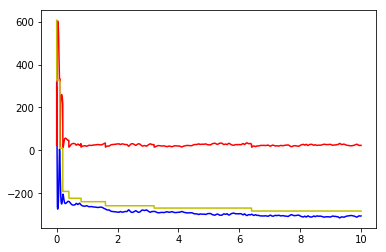

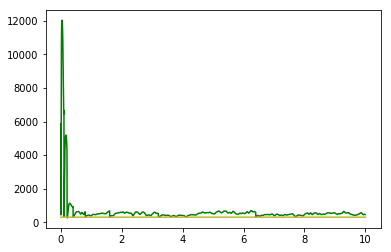

In [1353]:
plt.plot(t_range,E_pot,'b')
plt.plot(t_range,E_kin,'r')
plt.plot(t_range,E_kin+E_pot,'y')

plt.show()

plt.plot(t_range,T_tot,'g')
plt.plot(t_range,np.ones((len(t_range),1),dtype=float)*T,'y')

plt.show()



In [ ]:
from IPython.display import HTML

anim = make_3d_animation(L, pos, delay=10, initial_view=(30, 20), rotate_on_play=0)
HTML(anim.to_html5_video())